In [1]:
import os
import numpy as np
os.environ['TEJAPI_KEY'] = "sPWb8jSlnKgGZG9It37sotLF9DiwMf"
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"

import pandas as pd

from zipline.pipeline import Pipeline
from logbook import Logger, StderrHandler, INFO

log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

In [2]:
from zipline.sources.TEJ_Api_Data import get_universe
start = '2020-01-01'
end = '2023-12-31'
pool = get_universe(start, end, mkt = ['TWSE', 'OTC'], stktp_e =['Common Stock-Foreign', 'Common Stock'])
pool[:10]

[2024-12-26 02:12:30.118947]: INFO: get_universe_TW: Filters：{'mkt': ['TWSE', 'OTC'], 'stktp_e': ['Common Stock-Foreign', 'Common Stock']}


Currently used TEJ API key call quota 1628/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 48916054/9223372036854775807 (0.0%)


['1101',
 '1102',
 '1103',
 '1104',
 '1108',
 '1109',
 '1110',
 '1201',
 '1203',
 '1210']

In [3]:
start_dt = pd.Timestamp(start, tz='utc')
end_dt = pd.Timestamp(end, tz='utc')

tickers = ' '.join(pool)

os.environ['mdate'] = start+' '+end
os.environ['ticker'] = tickers+' IR0001'

In [4]:
! zipline ingest -b tquant

Merging daily equity files:
Currently used TEJ API key call quota 1634/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 52350754/9223372036854775807 (0.0%)


[2024-12-26 02:12:42.177525] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-12-26 02:15:44.750450] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [5]:
import tejapi

# 從 API 取得 TWN/APIBSTN1 董監全體持股狀況
data = tejapi.fastget(
    'TWN/APIBSTN1',
    coid=pool,
    mdate={'gte':pd.Timestamp(start) - pd.DateOffset(months=2), 'lte':pd.Timestamp(end)},
    opts={'columns':['coid','mdate','fld005','fld005l']},
    paginate=True
).rename(columns={'fld005': 'Director_and_Supervisor_Holdings_Percentage',
                  'fld005l': 'Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period'})

# 董監持股比例須於每月 15 日前公布上個月的數據，因此先將 mdate（年月）先轉成名目每月十五號（均為次月十五號）
data['mdate'] = data['mdate'] + pd.DateOffset(months=1)
data['mdate'] = data['mdate'].apply(lambda x: x.replace(day=15))

# 將 NA 值替換為 'N/A'，避免後續 ffill 時填補到前一期資料
for i in ['Director_and_Supervisor_Holdings_Percentage',
          'Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period']:
    data[i] = np.where(data[i].isnull(), 'N/A', data[i])

In [6]:
# 生成每間公司所有日曆日的 DataFrame
days = pd.date_range(pd.Timestamp(start) - pd.DateOffset(months=2), end).tolist()
df_tradeday = pd.DataFrame({
        'coid':[tick for tick in pool for day in days],
        'mdate':days * len(pool)
    })

# 將 df_tradeday 合併 API 資料，並 foward ffill，同時把 'N/A' 替換回 np.nan
data = (
    df_tradeday.
    merge(data,on=['coid','mdate'], how='left').
    set_index(['coid','mdate']).
    sort_index().
    groupby(['coid']).
    ffill().
    reset_index().
    replace({'N/A': np.nan})
)

In [7]:
data[data.mdate>='2020-01-01'].head()

,coid,mdate,Director_and_Supervisor_Holdings_Percentage,Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period
61,1101,2020-01-01,14.31,0.0
62,1101,2020-01-02,14.31,0.0
63,1101,2020-01-03,14.31,0.0
64,1101,2020-01-04,14.31,0.0
65,1101,2020-01-05,14.31,0.0


In [8]:
from zipline.data import bundles

bundle = bundles.load('tquant')
sids = bundle.asset_finder.equities_sids
assets = bundle.asset_finder.retrieve_all(sids)
symbol_mapping_sid = {i.symbol:i.sid for i in assets}

# shift(1): 15 號公告的資料 16 號才能用，避免前視偏誤
transform_data = data.set_index(['coid', 'mdate']).unstack('coid').shift(1)
transform_data = transform_data.rename(columns = symbol_mapping_sid)
transform_data.index = transform_data.index.tz_localize('UTC')
transform_data.tail()

Director_and_Supervisor_Holdings_Percentage         \
coid                                                             0      1      
mdate                                                                          
2023-12-27 00:00:00+00:00                                        7.48  27.36   
2023-12-28 00:00:00+00:00                                        7.48  27.36   
2023-12-29 00:00:00+00:00                                        7.48  27.36   
2023-12-30 00:00:00+00:00                                        7.48  27.36   
2023-12-31 00:00:00+00:00                                        7.48  27.36   

                                                                   \
coid                                     2      3     4      5      
mdate                                                               
2023-12-27 00:00:00+00:00  17.150000000000002  24.14  3.95  36.37   
2023-12-28 00:00:00+00:00  17.150000000000002  24.14  3.95  36.37   
2023-12-29 00:00:00+00:00  17.150000000000002  24.14  3.95  36.37   
2023-12-30 00:00:00+00:00  17.150000000000002  24.14  3.95  36.37   
2023-12-31 00:00:00+00:00  17.150000000000002  24.14  3.95  36.37   

                                                                   ...  \
coid                                     6      7      8     9     ...   
mdate                                                              ...   
2023-12-27 00:00:00+00:00  31.400000000000002  14.55  28.84  13.0  ...   
2023-12-28 00:00:00+00:00  31.400000000000002  14.55  28.84  13.0  ...   
2023-12-29 00:00:00+00:00  31.400000000000002  14.55  28.84  13.0  ...   
2023-12-30 00:00:00+00:00  31.400000000000002  14.55  28.84  13.0  ...   
2023-12-31 00:00:00+00:00  31.400000000000002  14.55  28.84  13.0  ...   

                          Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period  \
coid                                                                                                1855   
mdate                                                                                                      
2023-12-27 00:00:00+00:00                                                0.0                               
2023-12-28 00:00:00+00:00                                                0.0                               
2023-12-29 00:00:00+00:00                                                0.0                               
2023-12-30 00:00:00+00:00                                                0.0                               
2023-12-31 00:00:00+00:00                                                0.0                               

                                                                             
coid                      1856 1857 1858   1859  1860 1861   1862 1863 1864  
mdate                                                                        
2023-12-27 00:00:00+00:00  0.0  0.0  0.0  -0.07  0.05  0.0  -0.01  0.0  0.0  
2023-12-28 00:00:00+00:00  0.0  0.0  0.0  -0.07  0.05  0.0  -0.01  0.0  0.0  
2023-12-29 00:00:00+00:00  0.0  0.0  0.0  -0.07  0.05  0.0  -0.01  0.0  0.0  
2023-12-30 00:00:00+00:00  0.0  0.0  0.0  -0.07  0.05  0.0  -0.01  0.0  0.0  
2023-12-31 00:00:00+00:00  0.0  0.0  0.0  -0.07  0.05  0.0  -0.01  0.0  0.0  

[5 rows x 3730 columns]

In [9]:
from zipline.pipeline.data.dataset import Column, DataSet
from zipline.pipeline.domain import TW_EQUITIES
from zipline.pipeline.loaders.frame import DataFrameLoader

class CustomDataset(DataSet):
    Director_and_Supervisor_Holdings_Percentage = Column(dtype=float)
    domain = TW_EQUITIES

inputs=[CustomDataset.Director_and_Supervisor_Holdings_Percentage]
Custom_loader = {i:DataFrameLoader(column=i, baseline=transform_data[i.name]) for i in inputs}
Custom_loader

{CustomDataset<TW>.Director_and_Supervisor_Holdings_Percentage::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x1d7b593db10>}

In [10]:
from zipline.pipeline import SimplePipelineEngine
from zipline.pipeline.data import EquityPricing
from zipline.pipeline.loaders import EquityPricingLoader
pricing_loader = EquityPricingLoader.without_fx(bundle.equity_daily_bar_reader, bundle.adjustment_reader)

def choose_loader(column):
    if column.name in EquityPricing._column_names:
        return pricing_loader
    elif column.name in CustomDataset._column_names:
        return Custom_loader[column]
    else:
        raise Exception('Column not available')

engine = SimplePipelineEngine(
    get_loader = choose_loader,
    asset_finder = bundle.asset_finder,
    default_domain = TW_EQUITIES
)

In [11]:
def compute_signals():
    # 讓 Pipeline 可以顯示對應日期的資料
    Dire = CustomDataset.Director_and_Supervisor_Holdings_Percentage.latest

    # filter
    Director_and_Supervisor_Holdings_Percentage_filter = (CustomDataset.Director_and_Supervisor_Holdings_Percentage.latest > 40)
    # 當董監事持股比率 > 40 時，則表示為 True。

    return Pipeline(columns={
        'Dire':Dire,
        'longs' : Director_and_Supervisor_Holdings_Percentage_filter
        },
    )
    # algo 會買入 "longs" 欄位為 True 的股票並出清為 False 的持股。

In [12]:
pipeline_result = engine.run_pipeline(compute_signals(), start, end)
pipeline_result.head()

Dire  longs
2020-01-03 00:00:00+00:00 Equity(0 [1101])  14.31  False
                          Equity(1 [1102])  29.01  False
                          Equity(2 [1103])  17.11  False
                          Equity(3 [1104])  24.13  False
                          Equity(4 [1108])   3.95  False

In [13]:
pipeline_result.query("longs == 1")

Dire  longs
2020-01-03 00:00:00+00:00 Equity(5 [1109])     41.75   True
                          Equity(21 [1232])    67.93   True
                          Equity(24 [1235])    47.69   True
                          Equity(27 [1256])    56.97   True
                          Equity(28 [1258])    43.22   True
...                                              ...    ...
2023-12-29 00:00:00+00:00 Equity(1834 [9918])  40.79   True
                          Equity(1841 [9928])  51.43   True
                          Equity(1843 [9930])  68.64   True
                          Equity(1852 [9941])  43.97   True
                          Equity(1859 [9950])  54.25   True

[269181 rows x 2 columns]

In [14]:
# idx = pd.IndexSlice
# pipeline_result.loc[idx['2022-11-30':'2023-01-07', bundle.asset_finder.lookup_symbols(['2330'], as_of_date=None),:]]

In [15]:
# pipeline_result[pipeline_result.Dire.isnull()].index.get_level_values(1).unique()

# 正式開始回測

In [16]:
# 取出所有交易日
from zipline.utils.calendar_utils import get_calendar 
cal = get_calendar('TEJ').all_sessions
cal = cal[(cal >= '2020-01-01') & (cal <= '2023-12-31')]
cal[-10:]

DatetimeIndex(['2023-12-18 00:00:00+00:00', '2023-12-19 00:00:00+00:00',
               '2023-12-20 00:00:00+00:00', '2023-12-21 00:00:00+00:00',
               '2023-12-22 00:00:00+00:00', '2023-12-25 00:00:00+00:00',
               '2023-12-26 00:00:00+00:00', '2023-12-27 00:00:00+00:00',
               '2023-12-28 00:00:00+00:00', '2023-12-29 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='C')

In [17]:
# 計算每個交易日距離每月16日的距離
cal = pd.DataFrame(cal).rename(columns={0:'date'})
cal['diff'] = cal['date'].transform(lambda x: x - pd.Timestamp(year=x.year, month=x.month, day=16, tz='UTC'))
cal.tail(10)

,date,diff
964,2023-12-18 00:00:00+00:00,2 days
965,2023-12-19 00:00:00+00:00,3 days
966,2023-12-20 00:00:00+00:00,4 days
967,2023-12-21 00:00:00+00:00,5 days
968,2023-12-22 00:00:00+00:00,6 days
969,2023-12-25 00:00:00+00:00,9 days
970,2023-12-26 00:00:00+00:00,10 days
971,2023-12-27 00:00:00+00:00,11 days
972,2023-12-28 00:00:00+00:00,12 days
973,2023-12-29 00:00:00+00:00,13 days


In [18]:
# 篩選出平衡日期（取每月16日（含）後的第一個交易日），並轉為字串
tradeday = cal.groupby([cal['date'].dt.year, cal['date'].dt.month]).apply(lambda x: x[x['diff'].ge(pd.Timedelta(days=0))].head(1)).date.tolist()
tradeday = [str(i.date()) for i in tradeday]
tradeday[-10:]

['2023-03-16',
 '2023-04-17',
 '2023-05-16',
 '2023-06-16',
 '2023-07-17',
 '2023-08-16',
 '2023-09-18',
 '2023-10-16',
 '2023-11-16',
 '2023-12-18']

In [19]:
from zipline.algo.pipeline_algo import *

algo = TargetPercentPipeAlgo(
    start_session=start_dt,
    end_session=end_dt,
    capital_base=1e6,
    tradeday=tradeday,
    max_leverage=1,
    slippage_model=slippage.VolumeShareSlippage(volume_limit=0.15, price_impact=0.01),
    pipeline=compute_signals,
    custom_loader = Custom_loader
)
results = algo.run()

[2024-12-26 02:16:12.334321]: INFO: handle_split: after split: asset: Equity(1269 [6023]), amount: 62, cost_basis: 55.67, last_sale_price: 55.800000000000004
[2024-12-26 02:16:12.334321]: INFO: handle_split: returning cash: 34.36
[2024-12-26 02:16:13.121044]: INFO: rebalance: Cancel_order: current time: 2020-02-17 , created: 2020-01-16 , asset: Equity(1273 [6103]), amount: 392 , filled: 0
[2024-12-26 02:16:13.121044]: INFO: rebalance: Cancel_order: current time: 2020-02-17 , created: 2020-01-16 , asset: Equity(1387 [6236]), amount: 331 , filled: 0
[2024-12-26 02:16:17.162839]: INFO: handle_split: after split: asset: Equity(1006 [4563]), amount: 68, cost_basis: 46.99, last_sale_price: 46.7
[2024-12-26 02:16:17.164678]: INFO: handle_split: returning cash: 37.47
[2024-12-26 02:16:17.946997]: INFO: handle_split: after split: asset: Equity(1270 [6024]), amount: 82, cost_basis: 42.27, last_sale_price: 44.75
[2024-12-26 02:16:17.947999]: INFO: handle_split: returning cash: 3.45
[2024-12-26 02

In [20]:
from zipline.utils.run_algo import get_transaction_detail

positions, transactions, orders = get_transaction_detail(results)

In [21]:
orders.head()

,sid,symbol,id,dt,reason,created,amount,filled,commission,stop,limit,stop_reached,limit_reached,asset,status
2020-01-16 13:30:00+08:00,513,2729,743c90d3055c429f8530906a7219961f,2020-01-16 13:30:00+08:00,None,2020-01-16 13:30:00+08:00,12,0,0.0,None,None,False,False,Equity(513 [2729]),0
2020-01-16 13:30:00+08:00,1539,6640,28a704de4fff4df08e991e033afd8696,2020-01-16 13:30:00+08:00,None,2020-01-16 13:30:00+08:00,82,0,0.0,None,None,False,False,Equity(1539 [6640]),0
2020-01-16 13:30:00+08:00,516,2734,c1206411da524168b01636fb3507e8d1,2020-01-16 13:30:00+08:00,None,2020-01-16 13:30:00+08:00,277,0,0.0,None,None,False,False,Equity(516 [2734]),0
2020-01-16 13:30:00+08:00,5,1109,ab42afad95564e6ca7586c5d7a9fe5ca,2020-01-16 13:30:00+08:00,None,2020-01-16 13:30:00+08:00,172,0,0.0,None,None,False,False,Equity(5 [1109]),0
2020-01-16 13:30:00+08:00,518,2739,d6eb823bce19443eaa27a6e1139d5341,2020-01-16 13:30:00+08:00,None,2020-01-16 13:30:00+08:00,134,0,0.0,None,None,False,False,Equity(518 [2739]),0


Start date,2020-01-02
End date,2023-12-29
Total months,46
,Backtest
Annual return,15.145%
Annual volatility,15.558%
Sharpe ratio,0.99
Calmar ratio,0.50
Stability,0.83
Max drawdown,-30.345%
Omega ratio,1.20


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.34,2020-01-16,2020-03-19,2020-07-01,107
1,16.19,2021-04-28,2021-05-17,2021-07-16,56
2,15.75,2022-01-04,2022-10-26,2023-02-21,273
3,7.07,2021-07-19,2021-08-19,2021-11-01,73
4,6.96,2020-07-09,2020-07-28,2020-09-02,40


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the foll

Top 10 long positions of all time,max
sid,
4131,1.41%
2719,0.91%
3287,0.83%
4944,0.83%
3373,0.82%
5344,0.79%
4192,0.78%
3046,0.77%
1456,0.76%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
4131,1.41%
2719,0.91%
3287,0.83%
4944,0.83%
3373,0.82%
5344,0.79%
4192,0.78%
3046,0.77%
1456,0.76%


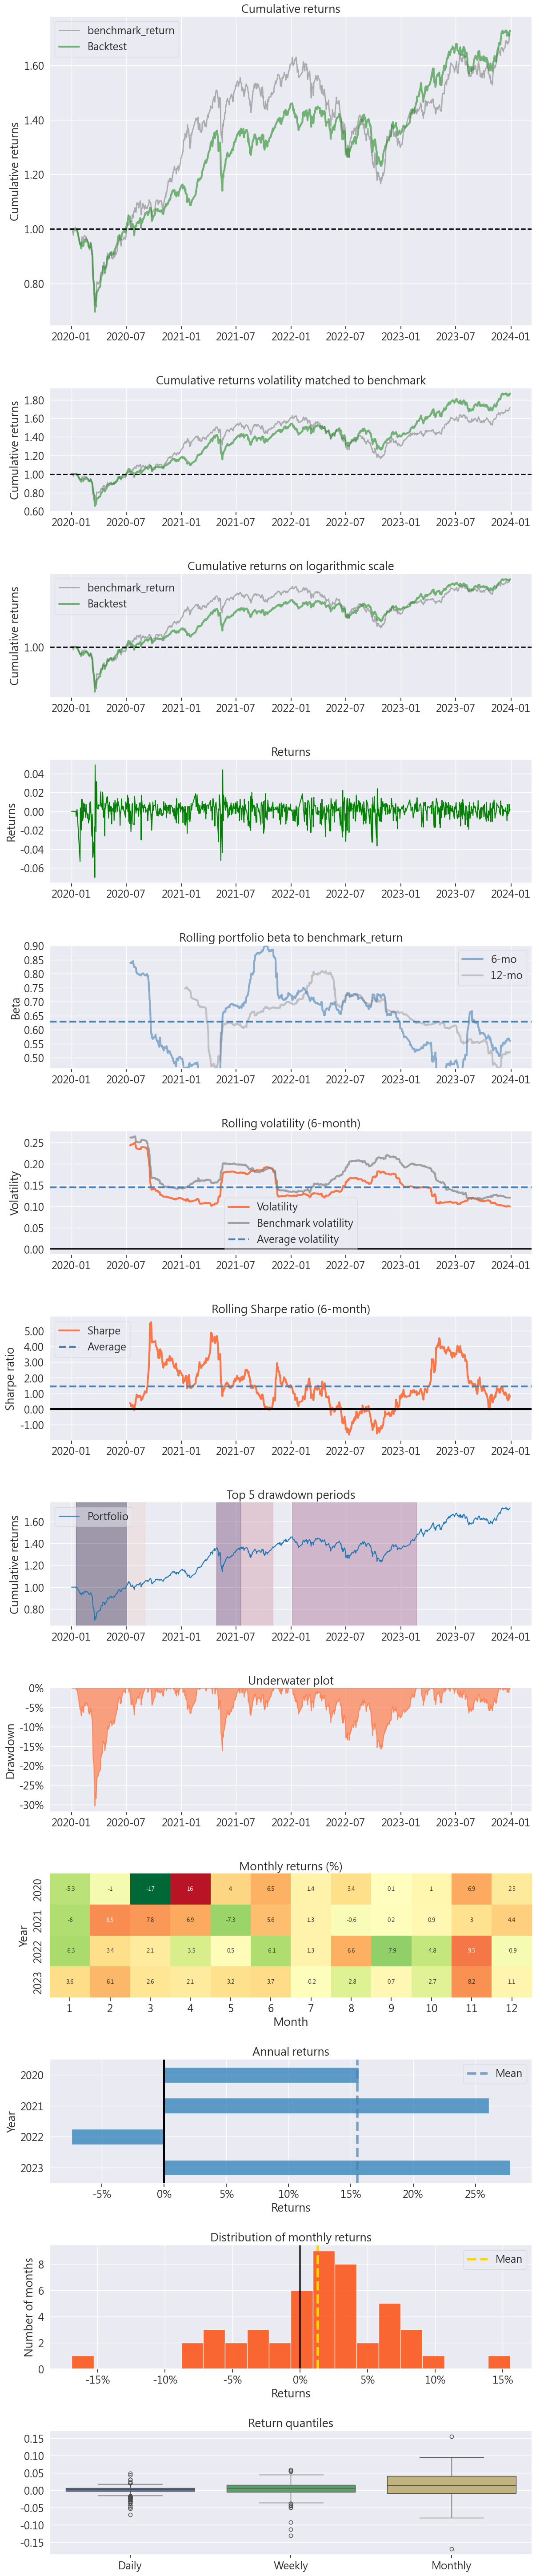

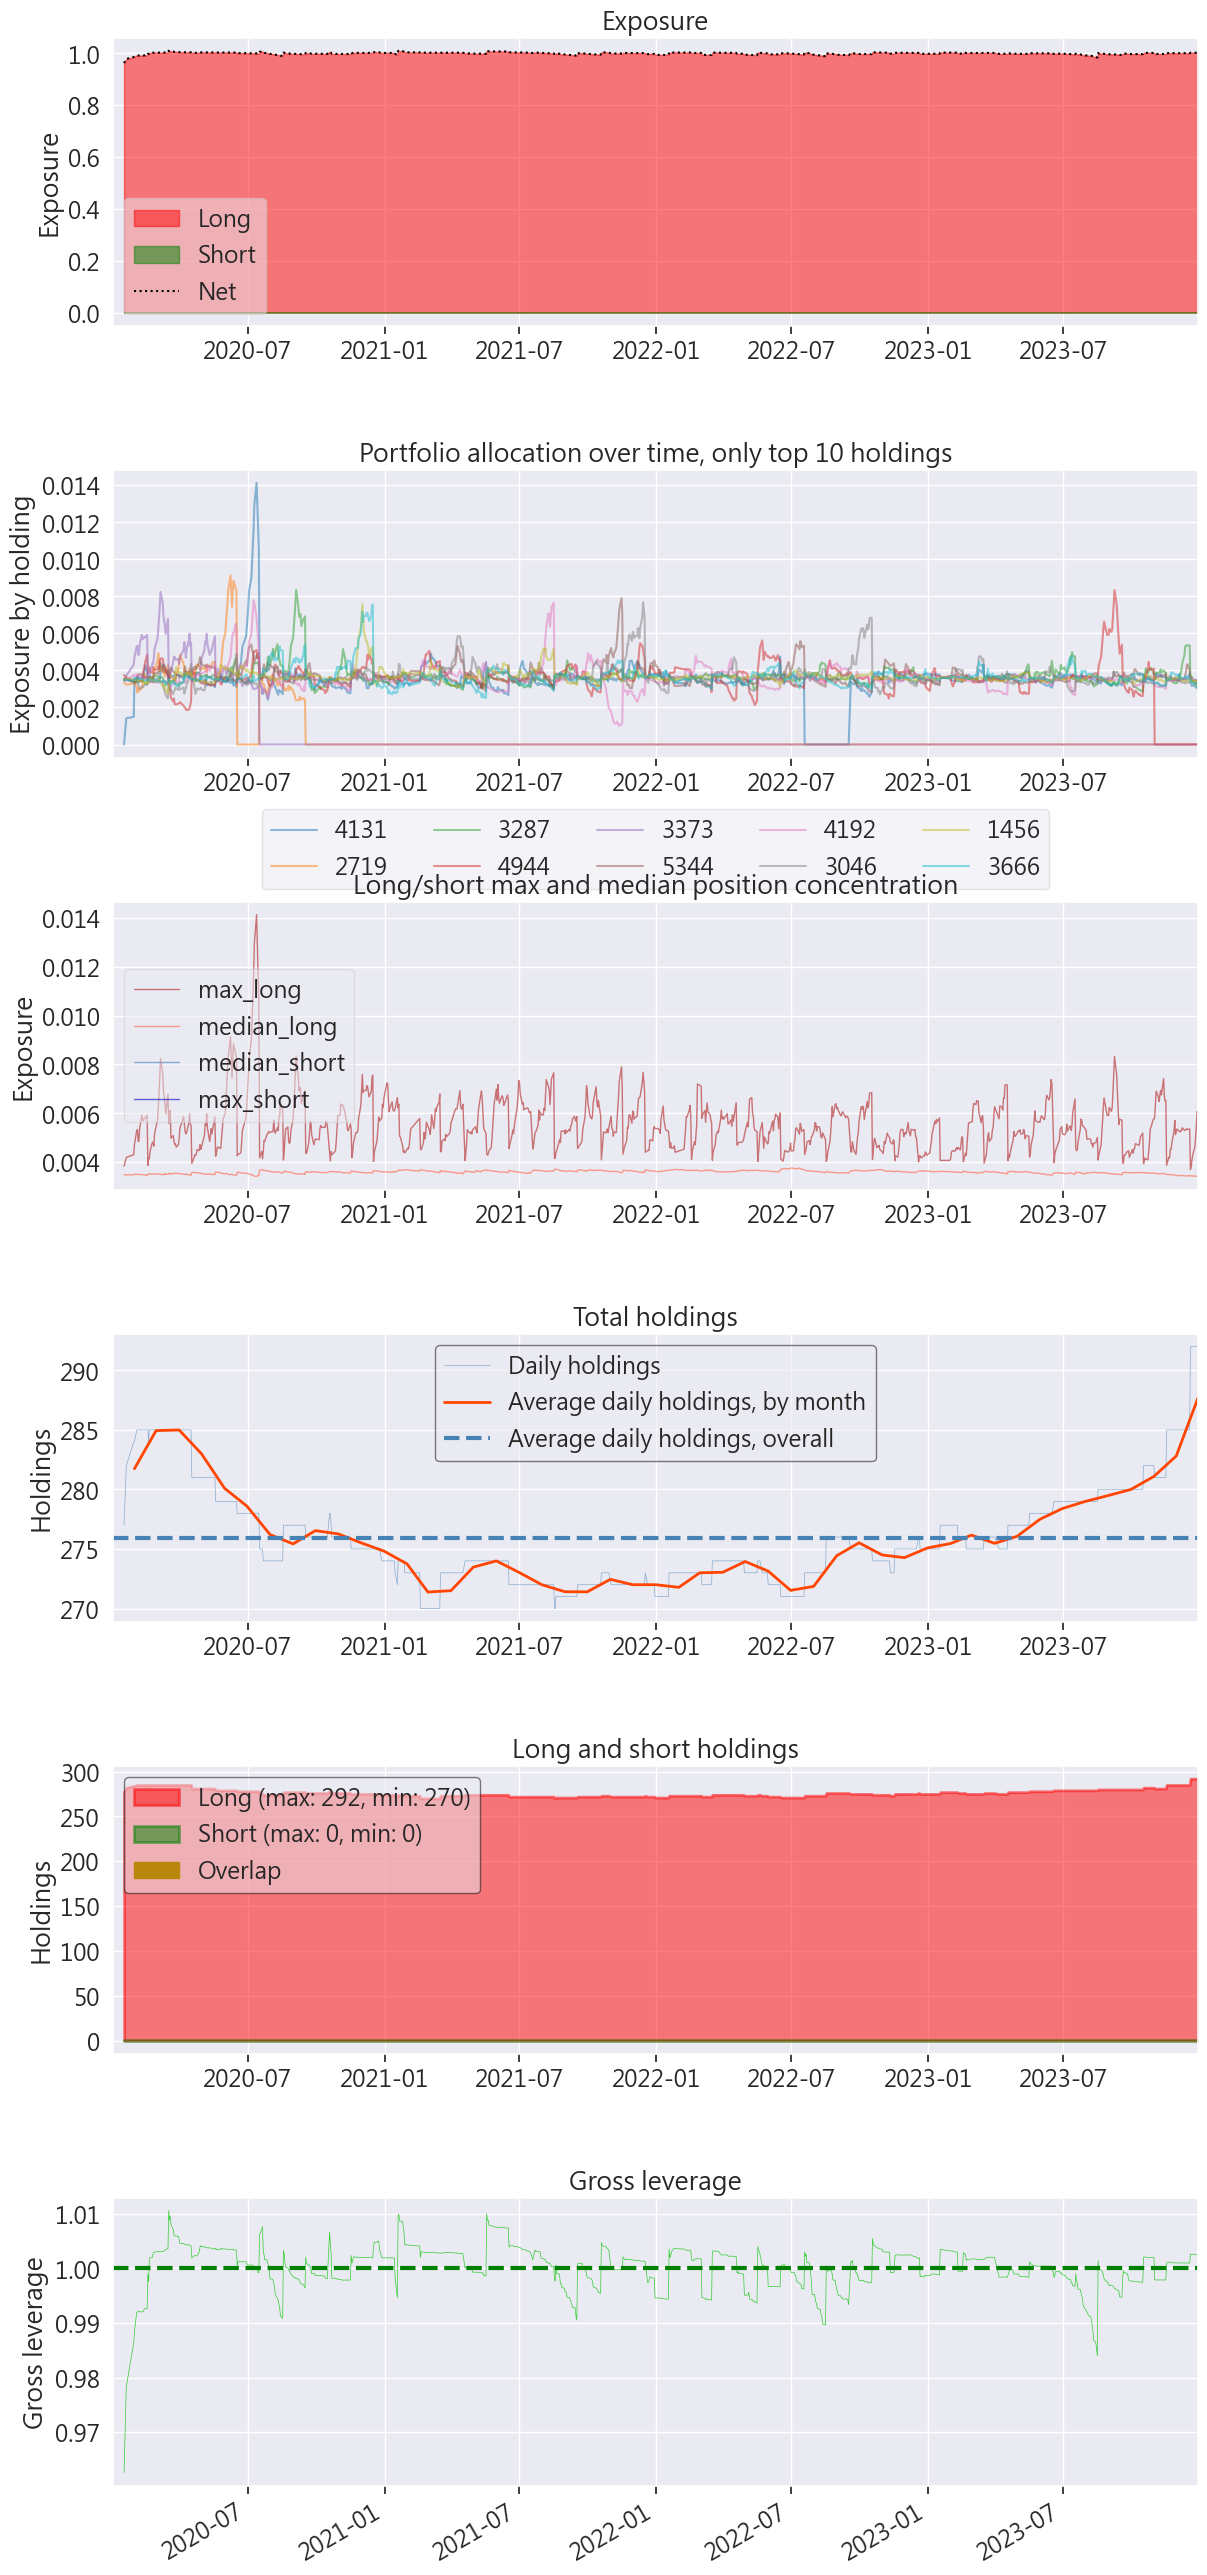

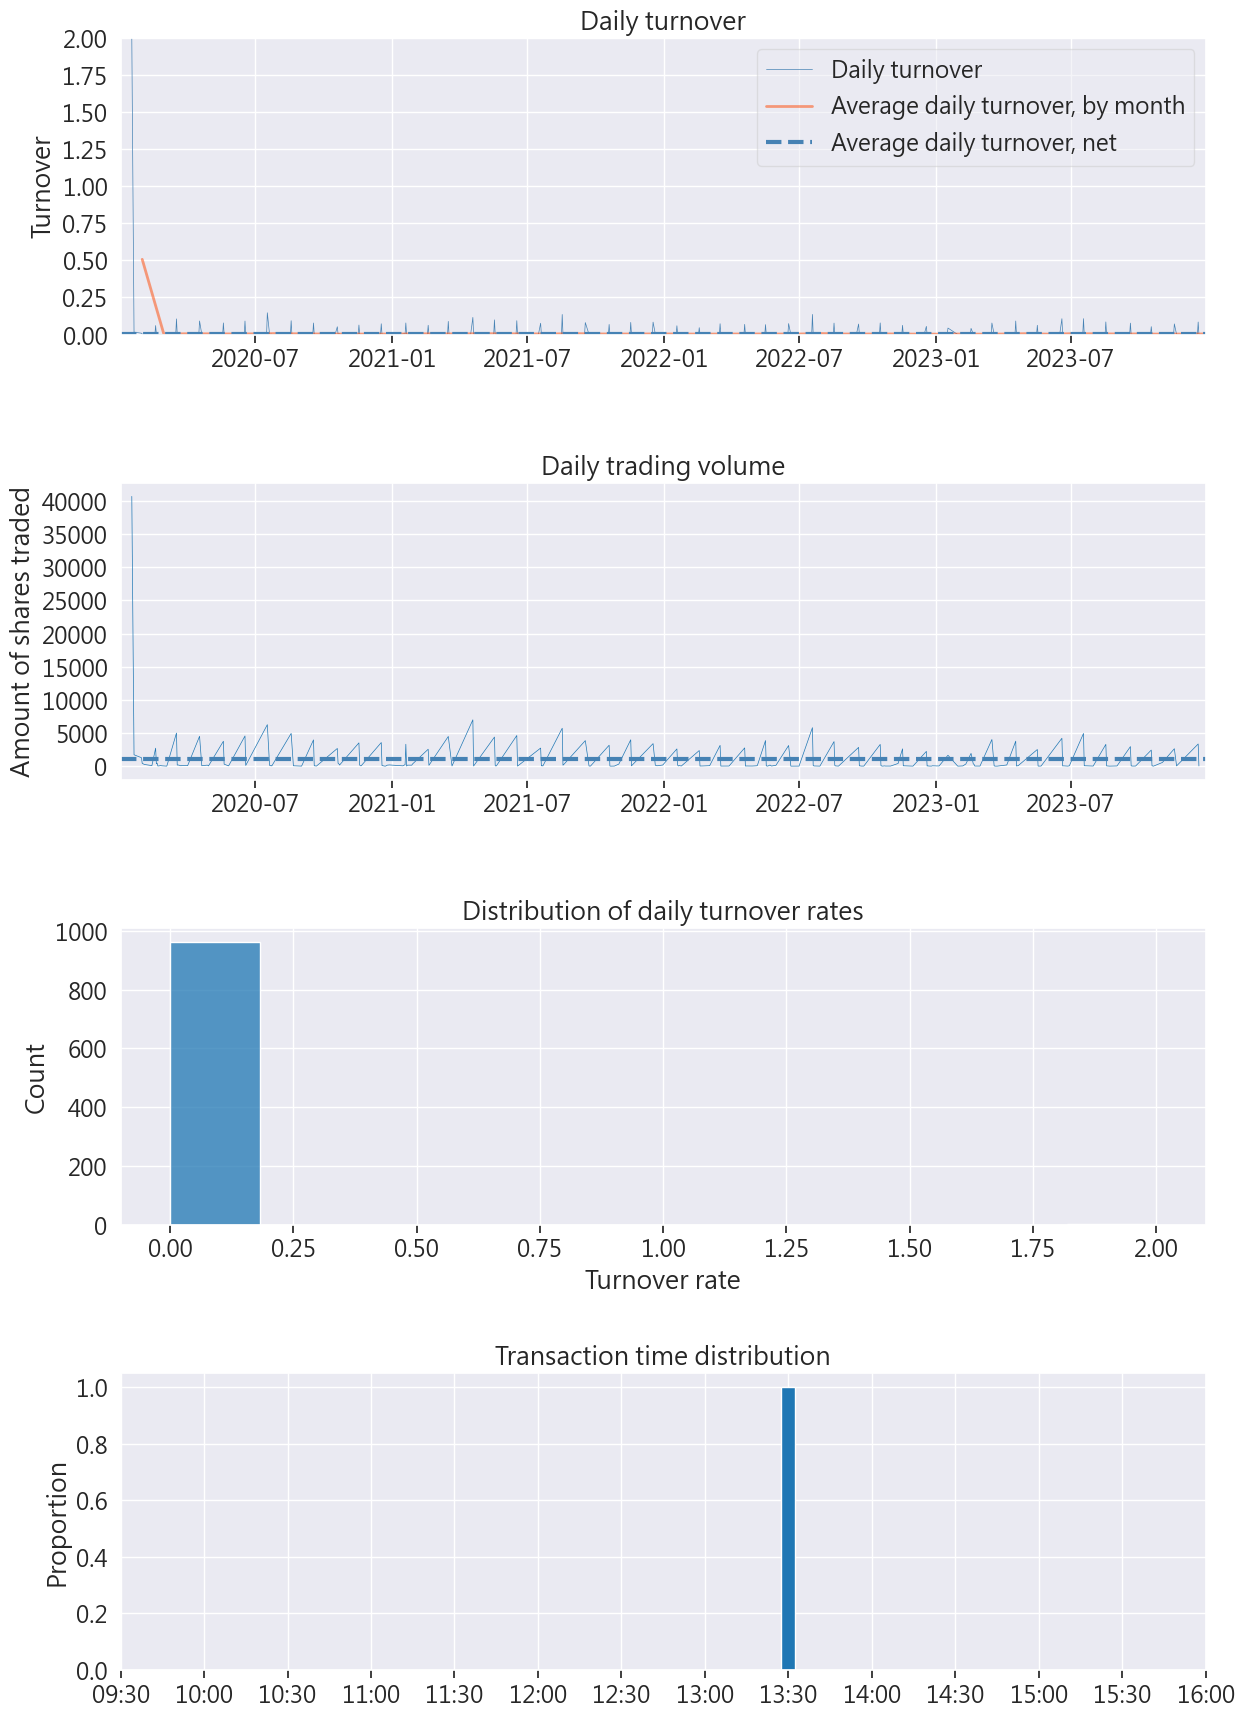

In [22]:
import pyfolio as pf

returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

# Creating a Full Tear Sheet
pf.create_full_tear_sheet(
    returns=returns,
    positions=positions,
    transactions=transactions,
    benchmark_rets=benchmark_rets
)

In [23]:
# 大盤表現
# pf.create_full_tear_sheet(returns=benchmark_rets)